In [36]:
import torch
import numpy as np
from sklearn.preprocessing import StandardScaler




import xlrd
import pandas as pd

book = xlrd.open_workbook('kinetic data for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data_unreplicated = [[sheet.cell_value(r, c)
         for c in range(0,7)] for r in range(0,300)]
scaler = StandardScaler()
scaler.fit(data_unreplicated)
book = xlrd.open_workbook('prepareddatakinetic.xlsx')
sheet = book.sheet_by_name('Sheet1')
replicated_data = [[sheet.cell_value(r, c)
         for c in range(0,7)] for r in range(0,15000)]

scaler = StandardScaler()
scaler.fit(data_unreplicated)
standardised_data = scaler.transform(replicated_data)
x=torch.tensor(standardised_data)

def create_inout_sequences(input_data, tw):
    training_seq = []
    label_seq = []
    L = len(input_data)
    for i in range(0,L,tw):
        train_seq = input_data[i:i+tw,0:4]
        train_label = input_data[i:i+tw,4:7]
        training_seq.append(train_seq)
        label_seq.append(train_label)
    return training_seq,label_seq

z, t = create_inout_sequences(x, 25)
x_train = torch.stack(z)
y_train = torch.stack(t)
batch_size = 4
train = torch.utils.data.TensorDataset(x_train,y_train)
train_loader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size, 
                                           shuffle=True)






In [37]:
import torch.nn as nn
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNNModel, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.layer_dim = layer_dim

        # Building your RNN
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='tanh')

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # One time step
        # We need to detach the hidden state to prevent exploding/vanishing gradients
        # This is part of truncated backpropagation through time (BPTT)
        out, hn = self.rnn(x, h0.detach())

        # Index hidden state of last time step
        # out.size() --> 100, 28, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out) 
        # out.size() --> 100, 10
        return out

In [38]:
import torch
input_dim = 4
hidden_dim = 20
layer_dim = 1 
output_dim = 3

model = RNNModel(input_dim, hidden_dim, layer_dim, output_dim)
loss_fn = torch.nn.MSELoss(reduction='mean')

In [39]:
from tqdm import tqdm
from torch.autograd import Variable
model.train()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 40
for epoch in range (epochs):
    for x_batch, y_batch in train_loader:
        y_pred = model(x_batch.float())
        loss = loss_fn(y_pred, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(epoch, loss.item())



0 0.38725000619888306
1 0.25369226932525635
2 0.414669394493103
3 0.36445561051368713
4 0.2600180506706238
5 0.12883946299552917
6 0.32350262999534607
7 0.13747388124465942
8 0.3550625145435333
9 0.20849083364009857
10 0.15448768436908722
11 0.24631698429584503
12 0.15250317752361298
13 0.3778710663318634
14 0.033119507133960724
15 0.18224753439426422
16 0.1541062444448471
17 0.3597720265388489
18 0.3917180895805359
19 0.3435654938220978
20 0.2193548083305359
21 0.2102271020412445
22 0.20745639503002167
23 0.1665104478597641
24 0.13310080766677856
25 0.11134248226881027
26 0.1900426149368286
27 0.24116308987140656
28 0.4101274013519287
29 0.18050335347652435
30 0.3702593445777893
31 0.0867246687412262
32 0.36689525842666626
33 0.23201298713684082
34 0.10238916426897049
35 0.2074575424194336
36 0.1425350308418274
37 0.1509350836277008
38 0.24811428785324097
39 0.3648340702056885


In [40]:
torch.save(model.state_dict(), ("C:/Users/Gabriel/Documents/Python/RNNkinetic.pt"))                
                                

In [41]:
import xlrd
import numpy as np
from sklearn.preprocessing import StandardScaler
model.load_state_dict(torch.load("C:/Users/Gabriel/Documents/Python/RNNkinetic.pt"))
model.eval()
book = xlrd.open_workbook('kinetic data for standardisation.xlsx')
sheet = book.sheet_by_name('Sheet1')
data4 = [[sheet.cell_value(r, c)
         for c in range(0,4)] for r in range(0,300)]
data5 = [[sheet.cell_value(r, c)
         for c in range(4,7)] for r in range(0,300)]
scaler = StandardScaler()
scaler2 = StandardScaler()

In [42]:
book = xlrd.open_workbook('kinetic data complete with gradient.xlsx')
sheet = book.sheet_by_name('Sheet1')

data = [[sheet.cell_value(r, c)
         for c in range(0,4)] for r in range(315,340)]
data2 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(315,340)]
data3 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(316,341)]
actual_results = torch.tensor(data3)

scaler.fit(data4)
scaler2.fit(data5)
n = np.array(data)
q= torch.tensor(n[0:1,:])
standardised_data = scaler.transform(data)

standardised_data2 = standardised_data[:, 0:3] 



x_raw = torch.tensor(standardised_data[0:1,:])
z = torch.tensor(standardised_data2[0:1,:])
v = torch.tensor(data3)

results=[]
for i in range(25):
     with torch.no_grad():
        x=x_raw.view(1,1+i,4)
        dx_dt_pred = model(x.float())
        predictions= np.array(dx_dt_pred)
        descaled_predictions = scaler2.inverse_transform(predictions)
        usable_predictions = torch.tensor(descaled_predictions)
        q[:, 0:3]  = (usable_predictions[:,i:i+1,:]*12) + q[:, 0:3]
        np_x = np.array(q)
        results.append(np_x[:, 0:3])
        standardised_data3 = scaler.transform(np_x)
        b_raw = torch.tensor(standardised_data3)
        b=b_raw.view(1,1,4)
        ug = torch.cat((x,b),1)
        x_raw=ug
    
predictions_final=torch.tensor(results)  

x_plot=predictions_final.view(25, 3)



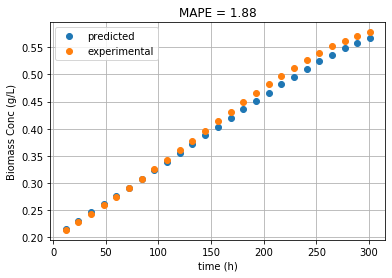

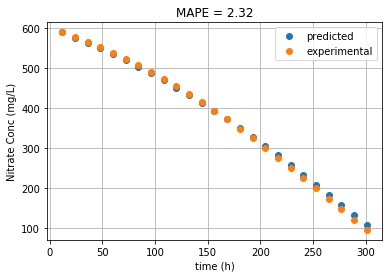

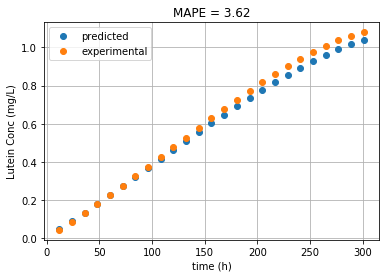

In [43]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-y_pred[i:1+i,:])/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100
    return MAPE_Total

import numpy as np
a = np.linspace(12,301,25)
v = torch.tensor(data3)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Lutein Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 



In [44]:
book = xlrd.open_workbook('kinetic data complete with gradient.xlsx')
sheet = book.sheet_by_name('Sheet1')

data = [[sheet.cell_value(r, c)
         for c in range(0,4)] for r in range(343,368)]
data2 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(343,369)]
data3 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(344,369)]
actual_results = torch.tensor(data3)

scaler.fit(data4)
scaler2.fit(data5)
n = np.array(data)
q= torch.tensor(n[0:1,:])
standardised_data = scaler.transform(data)

standardised_data2 = standardised_data[:, 0:3] 



x_raw = torch.tensor(standardised_data[0:1,:])
z = torch.tensor(standardised_data2[0:1,:])
v = torch.tensor(data3)

results=[]
for i in range(25):
     with torch.no_grad():
        x=x_raw.view(1,1+i,4)
        dx_dt_pred = model(x.float())
        predictions= np.array(dx_dt_pred)
        descaled_predictions = scaler2.inverse_transform(predictions)
        usable_predictions = torch.tensor(descaled_predictions)
        q[:, 0:3]  = (usable_predictions[:,i:i+1,:]*12) + q[:, 0:3]
        np_x = np.array(q)
        results.append(np_x[:, 0:3])
        standardised_data3 = scaler.transform(np_x)
        b_raw = torch.tensor(standardised_data3)
        b=b_raw.view(1,1,4)
        ug = torch.cat((x,b),1)
        x_raw=ug
    
predictions_final=torch.tensor(results)  

x_plot=predictions_final.view(25, 3)
print(x_plot)

print(v)

tensor([[ 2.2486e-01,  3.8935e+02,  5.9608e-02],
        [ 2.4882e-01,  3.7719e+02,  1.2643e-01],
        [ 2.7475e-01,  3.6363e+02,  1.9726e-01],
        [ 3.0302e-01,  3.4861e+02,  2.7458e-01],
        [ 3.3320e-01,  3.3221e+02,  3.5705e-01],
        [ 3.6450e-01,  3.1432e+02,  4.4381e-01],
        [ 3.9687e-01,  2.9488e+02,  5.3346e-01],
        [ 4.3026e-01,  2.7384e+02,  6.2497e-01],
        [ 4.6454e-01,  2.5122e+02,  7.1739e-01],
        [ 4.9944e-01,  2.2706e+02,  8.0969e-01],
        [ 5.3448e-01,  2.0149e+02,  9.0062e-01],
        [ 5.6892e-01,  1.7474e+02,  9.8862e-01],
        [ 6.0176e-01,  1.4712e+02,  1.0718e+00],
        [ 6.3170e-01,  1.1909e+02,  1.1476e+00],
        [ 6.5719e-01,  9.1274e+01,  1.2130e+00],
        [ 6.7619e-01,  6.4642e+01,  1.2635e+00],
        [ 6.8599e-01,  4.0588e+01,  1.2925e+00],
        [ 6.8321e-01,  2.1034e+01,  1.2914e+00],
        [ 6.6531e-01,  8.0807e+00,  1.2526e+00],
        [ 6.3426e-01,  2.0847e+00,  1.1825e+00],
        [ 5.9762e-01

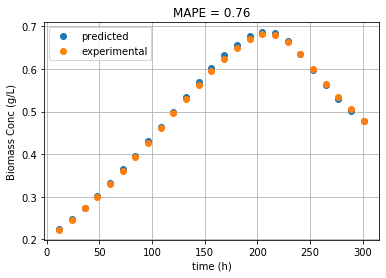

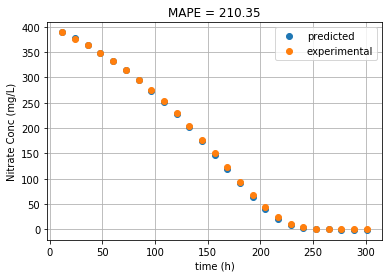

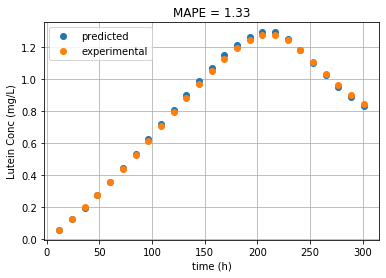

In [45]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-torch.abs(y_pred[i:1+i,:]))/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100 
    return MAPE_Total

import numpy as np
a = np.linspace(12,301,25)
v = torch.tensor(data3)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Lutein Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

In [46]:
book = xlrd.open_workbook('kinetic data complete with gradient.xlsx')
sheet = book.sheet_by_name('Sheet1')

data = [[sheet.cell_value(r, c)
         for c in range(0,4)] for r in range(371,396)]
data2 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(371,396)]
data3 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(372,397)]
actual_results = torch.tensor(data3)

scaler.fit(data4)
scaler2.fit(data5)
n = np.array(data)
q= torch.tensor(n[0:1,:])
standardised_data = scaler.transform(data)

standardised_data2 = standardised_data[:, 0:3] 



x_raw = torch.tensor(standardised_data[0:1,:])
z = torch.tensor(standardised_data2[0:1,:])
v = torch.tensor(data3)

results=[]
for i in range(25):
     with torch.no_grad():
        x=x_raw.view(1,1+i,4)
        dx_dt_pred = model(x.float())
        predictions= np.array(dx_dt_pred)
        descaled_predictions = scaler2.inverse_transform(predictions)
        usable_predictions = torch.tensor(descaled_predictions)
        q[:, 0:3]  = (usable_predictions[:,i:i+1,:]*12) + q[:, 0:3]
        np_x = np.array(q)
        results.append(np_x[:, 0:3])
        standardised_data3 = scaler.transform(np_x)
        b_raw = torch.tensor(standardised_data3)
        b=b_raw.view(1,1,4)
        ug = torch.cat((x,b),1)
        x_raw=ug
    
predictions_final=torch.tensor(results)  

x_plot=predictions_final.view(25, 3)


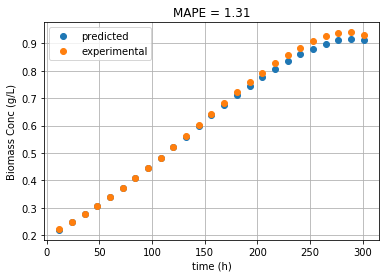

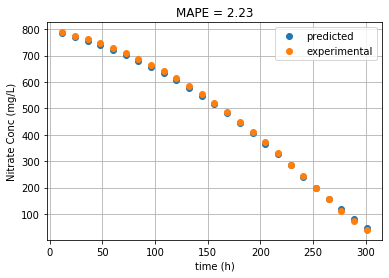

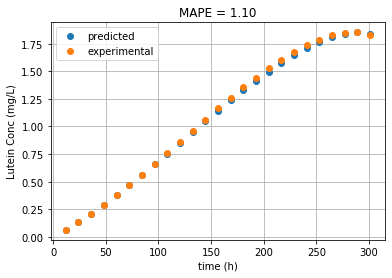

In [47]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-y_pred[i:1+i,:])/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100
    return MAPE_Total

import numpy as np
a = np.linspace(12,301,25)
v = torch.tensor(data3)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Lutein Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

In [48]:
book = xlrd.open_workbook('kinetic data complete with gradient.xlsx')
sheet = book.sheet_by_name('Sheet1')

data = [[sheet.cell_value(r, c)
         for c in range(0,4)] for r in range(399,424)]
data2 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(399,424)]
data3 = [[sheet.cell_value(r, c)
         for c in range(0,3)] for r in range(400,425)]
actual_results = torch.tensor(data3)

scaler.fit(data4)
scaler2.fit(data5)
n = np.array(data)
q= torch.tensor(n[0:1,:])
standardised_data = scaler.transform(data)

standardised_data2 = standardised_data[:, 0:3] 



x_raw = torch.tensor(standardised_data[0:1,:])
z = torch.tensor(standardised_data2[0:1,:])
v = torch.tensor(data3)

results=[]
for i in range(25):
     with torch.no_grad():
        x=x_raw.view(1,1+i,4)
        dx_dt_pred = model(x.float())
        predictions= np.array(dx_dt_pred)
        descaled_predictions = scaler2.inverse_transform(predictions)
        usable_predictions = torch.tensor(descaled_predictions)
        q[:, 0:3]  = (usable_predictions[:,i:i+1,:]*12) + q[:, 0:3]
        np_x = np.array(q)
        results.append(np_x[:, 0:3])
        standardised_data3 = scaler.transform(np_x)
        b_raw = torch.tensor(standardised_data3)
        b=b_raw.view(1,1,4)
        ug = torch.cat((x,b),1)
        x_raw=ug
    
predictions_final=torch.tensor(results)  

x_plot=predictions_final.view(25, 3)


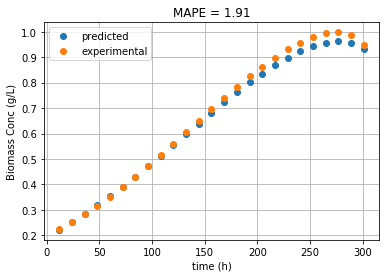

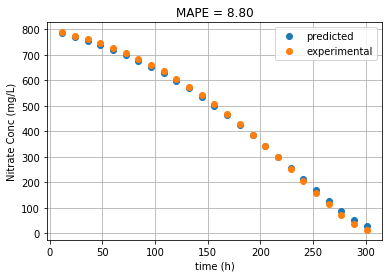

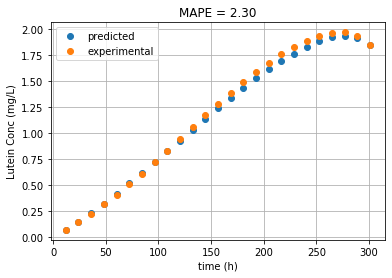

In [49]:
def MAPE(y_true, y_pred):
    MAPE_Total=0
    for i in range(len(y_pred)):
        MAPE = torch.abs((y_true[i:1+i,:]-y_pred[i:1+i,:])/y_true[i:1+i,:])
        MAPE_Total += (MAPE/len(y_pred))*100
    return MAPE_Total

import numpy as np
a = np.linspace(12,301,25)
v = torch.tensor(data3)
import matplotlib.pyplot as plt 
y1 = x_plot[:, 0:1] 
x1 = a
plt.plot(x1, y1,'o' ,label = "predicted") 

y2 = v[:, 0:1] 
x2 = a
plt.plot(x2, y2, 'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Biomass Conc (g/L)')
loss = MAPE(v[:, 0:1],x_plot[:, 0:1])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 


y1 = x_plot[:, 1:2] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 1:2] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Nitrate Conc (mg/L)')
loss = MAPE(v[:, 1:2],x_plot[:, 1:2])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 

y1 = x_plot[:, 2:3] 
x1 = a
plt.plot(x1, y1,'o',label = "predicted") 

y2 = v[:, 2:3] 
x2 = a
plt.plot(x2, y2,'o',label = "experimental") 
plt.xlabel('time (h)')
plt.ylabel('Lutein Conc (mg/L)')
loss = MAPE(v[:, 2:3],x_plot[:, 2:3])
plt.title(('MAPE = {:.2f}'.format(loss.item())))
plt.grid(b=True,which='major', axis='both')
plt.legend()
plt.show() 